In [ ]:
!pip install earthengine-api geemap rasterio patchify

In [21]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from patchify import patchify
import rasterio as rio
from rasterio.enums import Resampling
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import backend as K
import datetime
import ee
import geemap
import time
from google.colab import files, drive
from IPython.display import Image, display

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
path = "/content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset"

**Loading satellite images and their related ground truth labels**


In [24]:
image_combined_Data = np.load('/content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/sentinel_patches_germany_region.npy')   ##Sentinel-2 10 bands and Sentinel-1 2 bands
Ground_Truth_Data = np.load('/content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/reference_patches_germany_region.npy')
print(image_combined_Data.shape)
print(Ground_Truth_Data.shape)

(646, 128, 128, 12)
(646, 128, 128)


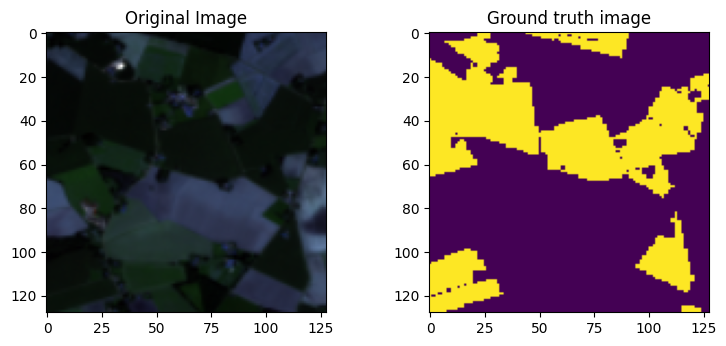

In [25]:
index=423
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(image_combined_Data[index,:,:,0:3])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(Ground_Truth_Data[index,:,: ])


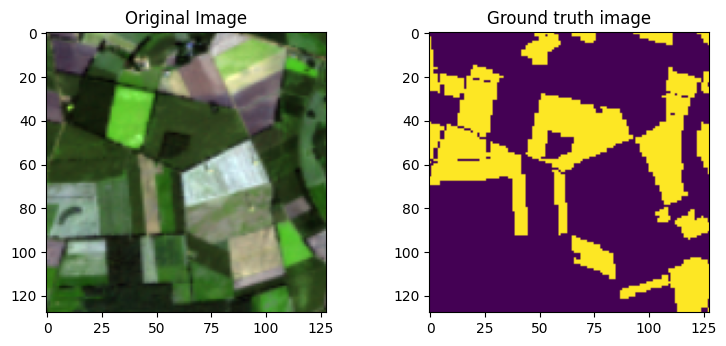

In [27]:
index=524
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(image_combined_Data[index,:,:,0:3])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(Ground_Truth_Data[index,:,: ])


**Defining Jacard Coefficent which is the relevant matrix for the AI model**

In [38]:
import tensorflow.keras.backend as K

def jacard_coef(y_true, y_pred, epsilon=1e-7):
    # Flatten and cast to float32
    y_true_flatten = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flatten = K.flatten(K.cast(y_pred, 'float32'))

    # Calculate intersection and union
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection

    # Add epsilon to avoid division by zero
    final_coef_value = (intersection + 1.0) / (union + epsilon + 1.0)

    return final_coef_value


**Splitting data to test and training**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(image_combined_Data, Ground_Truth_Data, test_size=0.12, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(568, 128, 128, 12)
(78, 128, 128, 12)
(568, 128, 128)
(78, 128, 128)


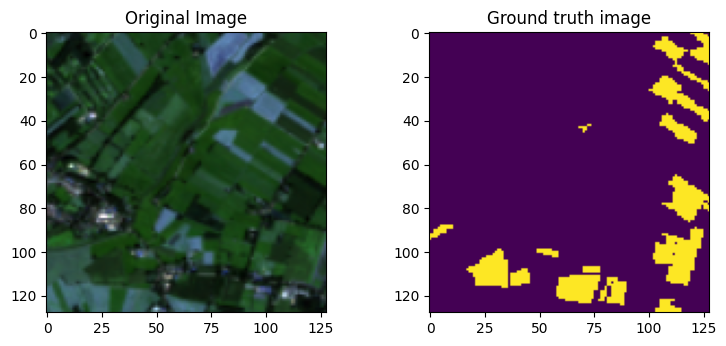

In [32]:
index=124
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(X_train[index,:,: , 0:3])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(y_train[index,:,: ])


**Building UNET Model**

In [39]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 12


# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x)(inputs)
START_FILTERS =16
# Contraction path (Encoder)
c1 = tf.keras.layers.Conv2D(START_FILTERS, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(s)
c1 = tf.keras.layers.Dropout(0.25)(c1)
c1 = tf.keras.layers.Conv2D(START_FILTERS, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2), data_format='channels_last')(c1)

c2 = tf.keras.layers.Conv2D(START_FILTERS * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(p1)
c2 = tf.keras.layers.Dropout(0.25)(c2)
c2 = tf.keras.layers.Conv2D(START_FILTERS * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2), data_format='channels_last')(c2)

c3 = tf.keras.layers.Conv2D(START_FILTERS * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(START_FILTERS * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2), data_format='channels_last')(c3)

c4 = tf.keras.layers.Conv2D(START_FILTERS * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(START_FILTERS * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(c4)

# Bottleneck
c5 = tf.keras.layers.Conv2D(START_FILTERS * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(START_FILTERS * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c5)

# Expansive path (Decoder)
u6 = tf.keras.layers.Conv2DTranspose(START_FILTERS * 8, (2, 2), strides=(2, 2), padding='same', data_format='channels_last')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(START_FILTERS * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(START_FILTERS * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c6)

u7 = tf.keras.layers.Conv2DTranspose(START_FILTERS * 4, (2, 2), strides=(2, 2), padding='same', data_format='channels_last')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(START_FILTERS * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(START_FILTERS * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c7)

u8 = tf.keras.layers.Conv2DTranspose(START_FILTERS * 2, (2, 2), strides=(2, 2), padding='same', data_format='channels_last')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(START_FILTERS * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(u8)
c8 = tf.keras.layers.Dropout(0.25)(c8)
c8 = tf.keras.layers.Conv2D(START_FILTERS * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c8)

u9 = tf.keras.layers.Conv2DTranspose(START_FILTERS, (2, 2), strides=(2, 2), padding='same', data_format='channels_last')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(START_FILTERS, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(START_FILTERS, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', data_format='channels_last')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', data_format='channels_last')(c9)

In [40]:
metrics = ["accuracy",jacard_coef]
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= 'adam' , loss = 'binary_crossentropy' , metrics = metrics)
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience=5, restore_best_weights=True)
          ,tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8 , verbose=1)]
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 128, 128, 12)   │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 16)   │          1,744 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 16)     │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 1,942,401 (7.41 MB)

 Trainable params: 1,942,401 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

**Start Training Process**

In [41]:
# training model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=16,callbacks = callback, verbose=1)

model.save("Germany_Corn_Version_1.h5")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


36/36 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.7812 - jacard_coef: 0.0982 - loss: 0.4993 - val_accuracy: 0.8486 - val_jacard_coef: 0.1822 - val_loss: 0.3300 - learning_rate: 0.0010
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.8564 - jacard_coef: 0.1869 - loss: 0.3206 - val_accuracy: 0.9010 - val_jacard_coef: 0.2933 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9012 - jacard_coef: 0.3281 - loss: 0.2572 - val_accuracy: 0.9190 - val_jacard_coef: 0.3920 - val_loss: 0.2168 - learning_rate: 0.0010
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9091 - jacard_coef: 0.3962 - loss: 0.2353 - val_accuracy: 0.9255 - val_jacard_coef: 0.4405 - val_loss: 0.2030 - learning_rate: 0.0010
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9213 - jacard_coef: 0.4321 - loss: 0.2077 - val_accuracy: 0.9314 - val_jacard_coef: 0.4915 - val_loss: 0.1847 - learning_rate: 0.0010
Epoch 6/25
36/36

**Calaculate Loss and accuarcy**

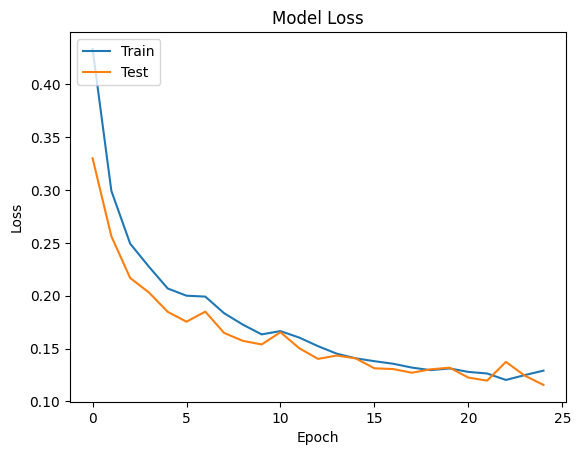

<Figure size 640x480 with 0 Axes>

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('Model_Loss.png')

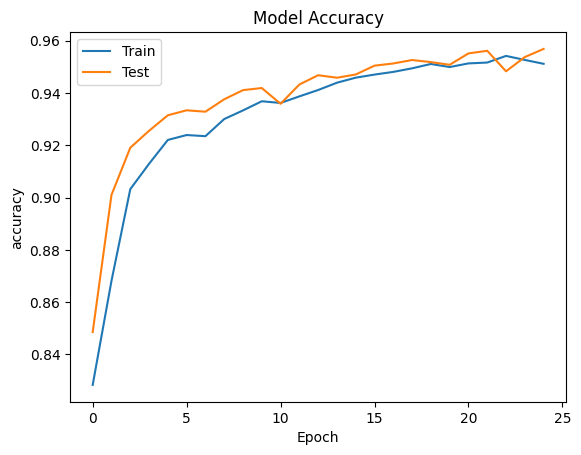

<Figure size 640x480 with 0 Axes>

In [43]:
# plot model loss over training and validation data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('Model_Accuracy.png')

**Predicting and testing model on test samples **

In [44]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(X_test)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)
print(y_test.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
(78, 128, 128, 1)
(78, 128, 128)


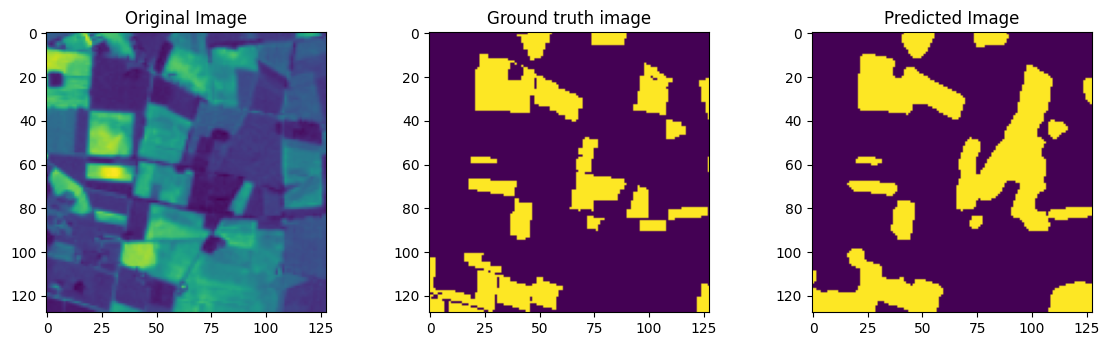

In [47]:
index =1
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(X_test[index,:,: , 0])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(y_test[index,:,: ])
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(pred_test[index, :, :])

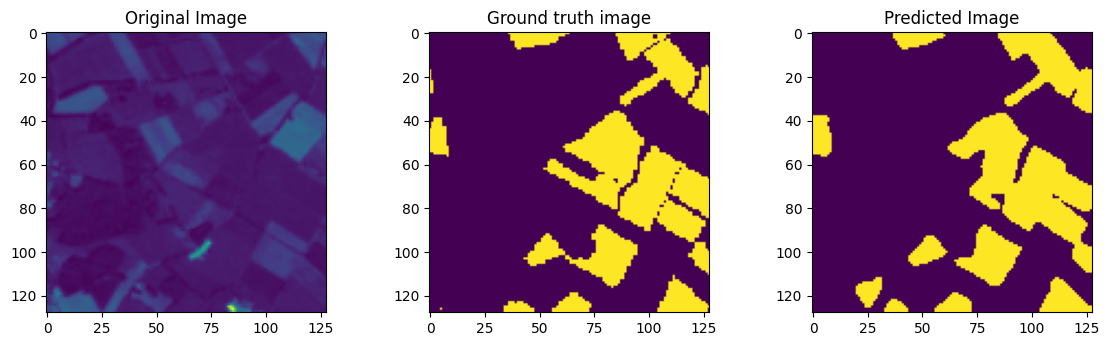

In [48]:
index =2
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(X_test[index,:,: , 0])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(y_test[index,:,: ])
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(pred_test[index, :, :])

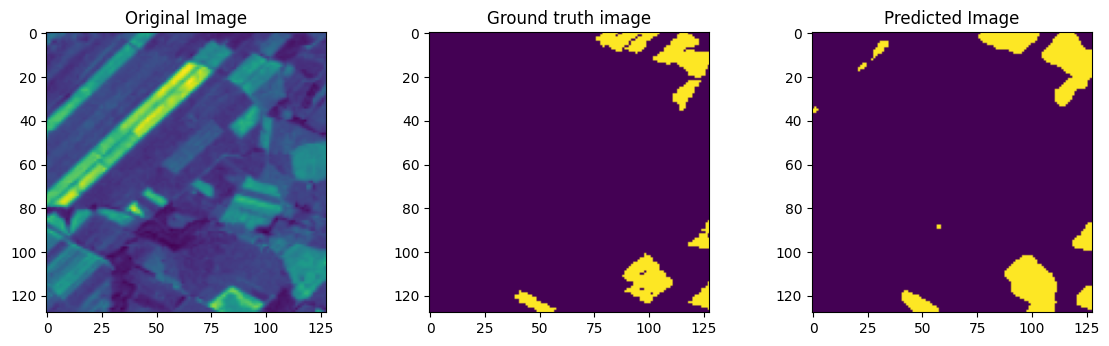

In [52]:
index =13
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(X_test[index,:,: , 0])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(y_test[index,:,: ])
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(pred_test[index, :, :])

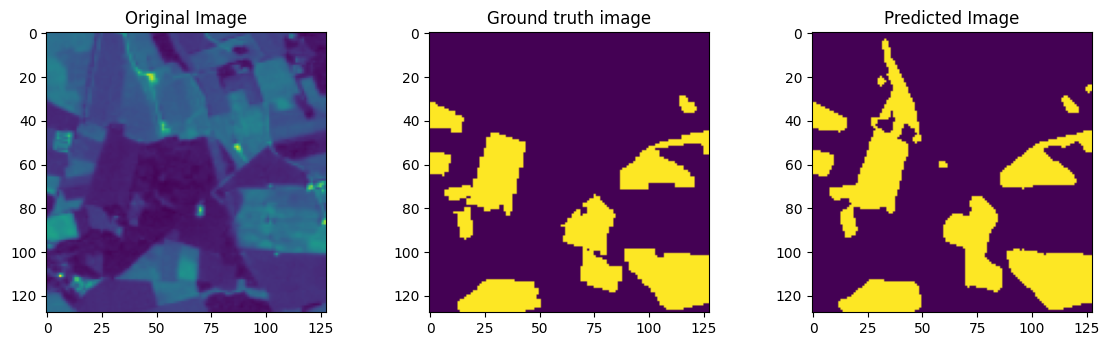

In [53]:
index =22
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(X_test[index,:,: , 0])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(y_test[index,:,: ])
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(pred_test[index, :, :])